In [11]:
mesh

PolyData (0x20c17121f60)
  N Cells:    19602
  N Points:   10000
  N Strips:   0
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -2.309e-14, 2.000e+01
  Z Bounds:   1.416e-01, 7.483e+00
  N Arrays:   2

In [6]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_cf import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/VEL_P_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
surface_mask = train_dataset.surface_mask

linear_ae_input_size = train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

ValueError: Velocities are not loaded, cannot scale.

In [7]:
train_dataset.h5_file[train_dataset.file_keys[0]].keys()  # ['Ux', 'Uy', 'Pressure', 'Cf', 'Y_plus', 'Re', 'Alpha']

<KeysViewHDF5 ['Cf', 'Cp', 'Pressure', 'Ux', 'Uy', 'coordinates', 'edge_index', 'parameters']>

In [ ]:
import pyvista as pv
from pyvista import examples

plotter = pv.Plotter()
mesh = examples.load_random_hills()

actor = plotter.add_mesh(mesh, cmap='terrain', show_scalar_bar=False)
plotter.show()

ValueError: Invalid colormap "Elevation"

In [1]:
from src.data.vtu_h5_rev import vtu_to_h5

vtu_to_h5(vtu_file_directory='./dataset/full', 
          output_h5_dir='./dataset/new_h5_files', 
          vtu_array_name='Velocity', 
          train_ratio=0.1, 
          scaling_type=4, 
          scaler_name='standard', 
          overwrite=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './dataset/full'

In [ ]:
import pickle

with open('./dataset/new_h5_files/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

[StandardScaler(), StandardScaler()]

In [21]:
import pyvista as pv

test =pv.read(r'dataset\high_flows\Re10000000\Re10000000_alpha_10\flow.vtu')
test

UnstructuredGrid (0x1d4653c9a20)
  N Cells:    229376
  N Points:   230336
  X Bounds:   -4.845e+02, 5.010e+02
  Y Bounds:   -5.078e+02, 5.078e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   12

In [22]:
clipped = test.clip_box(bounds=(-1,4,-1,1,0,1), invert=False, crinkle=True)
clipped

UnstructuredGrid (0x1d4653c9ba0)
  N Cells:    109638
  N Points:   110443
  X Bounds:   -1.076e+00, 4.039e+00
  Y Bounds:   -1.103e+00, 1.103e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   15

c:\Users\lab_aeroComp\anaconda3\envs\arvi-env\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


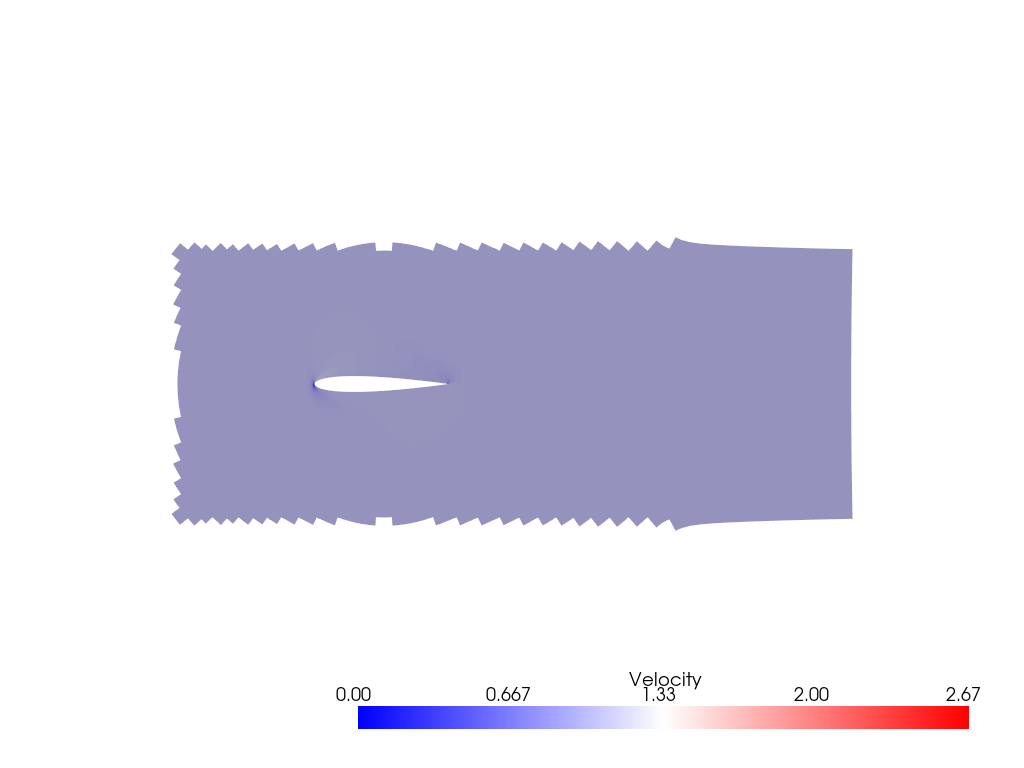

In [23]:
plotter = pv.Plotter()
plotter.add_mesh(clipped, scalars= 'Velocity',cmap='bwr', show_edges=False)
plotter.view_xy()
plotter.show()

# Apply scaling

In [ ]:
from src.data.apply_scaling import load_scalers, apply_scaling_to_h5_dataset

# Load the scalers that were saved during VTU conversion
scalers = load_scalers('./dataset/new_h5_files/scaler.pkl')

# Apply scaling to Ux only
apply_scaling_to_h5_dataset(
    h5_file_path='./dataset/new_h5_files/train.h5',
    variable_name='Ux',
    scaler=scalers['Ux'],
    scaling_type=4,  # SAMPLE-FEATURE SCALING
    output_path='./dataset/new_h5_files/train_scaled.h5'
)

In [1]:
from src.data.apply_scaling import load_scalers, apply_scaling_to_all_variables

# Load scalers
scalers = load_scalers('./dataset/new_h5_files/scaler.pkl')

# Apply scaling to all variables (now using the working approach)
apply_scaling_to_all_variables(
    h5_file_path='./dataset/new_h5_files/train.h5',
    scalers=scalers,
    scaling_type=4,
    output_path='./dataset/new_h5_files/train_scaled.h5'
)

Applying scaling to each variable...
Scaling Ux...
Scaling Uy...
Scaling Pressure...
Scaling Cp...
Scaling Cf...
Writing scaled data to H5 file...


'./dataset/new_h5_files/train_scaled.h5'

In [2]:
from src.data.apply_scaling import get_variable_statistics

# Check statistics before scaling
stats_before = get_variable_statistics('./dataset/new_h5_files/train.h5', 'Ux')
print(f"Before scaling - Min: {stats_before['min']:.6f}, Max: {stats_before['max']:.6f}")

# After scaling
stats_after = get_variable_statistics('./dataset/new_h5_files/train_scaled.h5', 'Ux')
print(f"After scaling - Min: {stats_after['min']:.6f}, Max: {stats_after['max']:.6f}")

Before scaling - Min: -0.867209, Max: 2.129537
After scaling - Min: -6.522560, Max: 6.528021


In [ ]:
# 1. Load your scalers
scalers = load_scalers('./dataset/new_h5_files/scaler.pkl')

# 2. Your model gives scaled predictions
model_scaled_output = your_model(scaled_input)  # Shape: [num_nodes, 1]

# 3. Inverse scale to get real-world values
real_world_prediction = inverse_scale_single_trajectory(
    model_scaled_output, 
    scalers['Ux'], 
    scaling_type=4
)

# Now real_world_prediction contains values in the original scale!

In [2]:
from src.data.vtu_h5_high import vtu_to_h5

vtu_to_h5(vtu_file_directory='./dataset/high_flows', 
          output_h5_dir='./dataset/new_h5_files', 
          vtu_array_name='Velocity', 
          train_ratio=0.1, 
        #   scaling_type=4, 
        #   scaler_name='standard', 
          overwrite=True)

Found 304 VTU files in directory structure
Pass 1: Reading all VTU files and extracting data...


Reading VTUs: 100%|██████████| 304/304 [00:24<00:00, 12.61it/s]


Found variables: ['Ux', 'Uy', 'Pressure', 'Cp', 'Cf']
Fitting simple scalers for each variable...
Fitting simple scaler for Ux...
  Training data shape for Ux: torch.Size([30, 230336, 1])
  Reshaped data shape for Ux: torch.Size([6910080, 1])
  Simple scaler fitted for Ux
  Mean: tensor([0.9482])
  Std: tensor([0.1703])
Fitting simple scaler for Uy...
  Training data shape for Uy: torch.Size([30, 230336, 1])
  Reshaped data shape for Uy: torch.Size([6910080, 1])
  Simple scaler fitted for Uy
  Mean: tensor([0.0920])
  Std: tensor([0.1349])
Fitting simple scaler for Pressure...
  Training data shape for Pressure: torch.Size([30, 230336, 1])
  Reshaped data shape for Pressure: torch.Size([6910080, 1])
  Simple scaler fitted for Pressure
  Mean: tensor([0.1931])
  Std: tensor([0.9847])
Fitting simple scaler for Cp...
  Training data shape for Cp: torch.Size([30, 230336, 1])
  Reshaped data shape for Cp: torch.Size([6910080, 1])
  Simple scaler fitted for Cp
  Mean: tensor([0.0056])
  Std:

Writing train.h5: 100%|██████████| 30/30 [00:00<00:00, 222.44it/s]


Writing validation data to ./dataset/new_h5_files\val.h5 (274 trajectories)


Writing val.h5: 100%|██████████| 274/274 [00:01<00:00, 228.84it/s]


VTU to H5 conversion with scaling and splitting complete. Output in ./dataset/new_h5_files


('./dataset/new_h5_files\\train.h5',
 './dataset/new_h5_files\\val.h5',
 './dataset/new_h5_files\\scaler.pkl')

In [3]:
import h5py

test = h5py.File('./dataset/new_h5_files/train.h5', 'r')

In [9]:
test_ = test[list(test.keys())[0]]

In [1]:
from src.data.apply_scaling import load_scalers, apply_scaling_to_all_variables

# Load scalers
scalers = load_scalers('./dataset/new_h5_files/scaler.pkl')

# Apply scaling to all variables (now using the working approach)
apply_scaling_to_all_variables(
    h5_file_path='./dataset/new_h5_files/val.h5',
    scalers=scalers,
    scaling_type=4,
    output_path='./dataset/new_h5_files/val_scaled.h5'
)

Found 274 trajectories
Applying scaling trajectory by trajectory...


Scaling trajectories:   0%|          | 0/274 [00:00<?, ?it/s]e:\13621034 Muhammad Arviano Yuono\STABLE\GAE-ROM\src\data\apply_scaling.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_data = torch.tensor(temp_f, dtype=torch.float32)
Scaling trajectories:   1%|          | 3/274 [00:00<00:11, 23.22it/s]

    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_0.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_1.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1

Scaling trajectories:   3%|▎         | 9/274 [00:00<00:10, 24.28it/s]

    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_12.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_13.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for tra

Scaling trajectories:   4%|▍         | 12/274 [00:00<00:10, 24.36it/s]

    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_4.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1000000.0_alpha_5.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1

Scaling trajectories:   7%|▋         | 18/274 [00:00<00:10, 24.37it/s]

    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_0.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_1.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: 

Scaling trajectories:   9%|▉         | 24/274 [00:00<00:10, 24.30it/s]

  ERROR scaling Cf for trajectory Re_10000000.0_alpha_13.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_14.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_2.0: operands could not be broadcast t

Scaling trajectories:  10%|▉         | 27/274 [00:01<00:10, 24.49it/s]

  ERROR scaling Cf for trajectory Re_10000000.0_alpha_6.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_7.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_10000000.0_alpha_8.0: operands could not be broadcast tog

Scaling trajectories:  12%|█▏        | 33/274 [00:01<00:09, 24.46it/s]

    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1500000.0_alpha_1.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1500000.0_alpha_10.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (

Scaling trajectories:  13%|█▎        | 35/274 [00:01<00:10, 23.67it/s]


    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1500000.0_alpha_15.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
    scaler_s.mean_.shape: (1,)
    scaler_f.mean_.shape: (6910080,)
  ERROR scaling Cf for trajectory Re_1500000.0_alpha_2.0: operands could not be broadcast together with shapes (2,230336) (6910080,1) 
  Using original data for this trajectory...


KeyboardInterrupt: 

In [5]:
scalers

{'Ux': [StandardScaler(), StandardScaler()],
 'Uy': [StandardScaler(), StandardScaler()],
 'Pressure': [StandardScaler(), StandardScaler()],
 'Cp': [StandardScaler(), StandardScaler()],
 'Cf': [StandardScaler(), StandardScaler()]}

In [1]:
# Check the actual node counts in your files
import h5py

# Check training data
with h5py.File('./dataset/new_h5_files/train_unscaled.h5', 'r') as f:
    for group_name in f.keys():
        if 'Ux' in f[group_name]:
            print(f"Train {group_name}: {f[group_name]['Ux'].shape}")

# Check validation data  
with h5py.File('./dataset/new_h5_files/val_unscaled.h5', 'r') as f:
    for group_name in f.keys():
        if 'Ux' in f[group_name]:
            print(f"Val {group_name}: {f[group_name]['Ux'].shape}")

Train Re_1000000.0_alpha_10.0: (230336,)
Train Re_1000000.0_alpha_15.0: (230336,)
Train Re_1000000.0_alpha_9.0: (230336,)
Train Re_10000000.0_alpha_11.0: (230336,)
Train Re_10000000.0_alpha_12.0: (230336,)
Train Re_10000000.0_alpha_4.0: (230336,)
Train Re_10000000.0_alpha_5.0: (230336,)
Train Re_10000000.0_alpha_6.0: (230336,)
Train Re_1500000.0_alpha_9.0: (230336,)
Train Re_3000000.0_alpha_5.0: (230336,)
Train Re_3500000.0_alpha_1.0: (230336,)
Train Re_4500000.0_alpha_14.0: (230336,)
Train Re_4500000.0_alpha_9.0: (230336,)
Train Re_5000000.0_alpha_10.0: (230336,)
Train Re_5000000.0_alpha_8.0: (230336,)
Train Re_6000000.0_alpha_10.0: (230336,)
Train Re_6000000.0_alpha_6.0: (230336,)
Train Re_6500000.0_alpha_12.0: (230336,)
Train Re_6500000.0_alpha_5.0: (230336,)
Train Re_7500000.0_alpha_11.0: (230336,)
Train Re_7500000.0_alpha_15.0: (230336,)
Train Re_7500000.0_alpha_2.0: (230336,)
Train Re_8000000.0_alpha_10.0: (230336,)
Train Re_8500000.0_alpha_13.0: (230336,)
Train Re_8500000.0_alph

In [2]:
from src.data.apply_scaling import load_scalers, apply_scaling_to_h5_dataset

# Load scalers
scalers = load_scalers('./dataset/new_h5_files/scaler.pkl')

ux_scaler = scalers['Ux']

# Apply scaling to all variables (now using the working approach)
apply_scaling_to_h5_dataset(
    h5_file_path='./dataset/new_h5_files/val_unscaled.h5',
    scaler=ux_scaler,
    scaling_type=4,
    variable_name='Ux',
    output_path='./dataset/Ux_h5_files/val.h5'
)

Applying scaling to Ux...


ValueError: X has 63112064 features, but StandardScaler is expecting 6910080 features as input.

In [15]:
ux_scaler[0].mean_

array([0.94383744])